# Multi Stream Live Chat Analysis Report

## Preprocessing

Looking at the dataset we found out that the sentiment of the messages is:
   * $4$ to identify a message with positive sentiment
   * $0$ to identify a message with negative sentiment

Then the first preprocessing step is to change all positive messages sentiment from $4$ to $1$.

Now speaking about the text data we have that since the dataset is composed by raw data from Twitter, each Twit must be preprocessed to be usable.

The pipeline used to preprocess the data is the following:
   1. Transform all the text in lower case
   2. Substitute emojis into text
   3. Explicit negations
   4. Replace any url with "URL"
   5. Replace user tags with "USR"
   6. Replace $3$ consecutive chars with $2$
   7. Remove consecutive spaces
   8. Remove hashtags
   9. Stemming
   
###### Lower Case

This is applied in order to don't distinguish between lower case and upper case words. In previous years people tend to enfatize expressions user all upper case sentences, but nowdays this is not a thing anymore and people just use emojis or a more direct text

###### Emojis

Here we will replace the most common emojis into their explicit form (i.e. ':)' will become 'smile'). This is used in order to make everything of the same form and reduce the complexity of models and word embeddings.

Also must be noticed that Twitch emojis are already in the explicit form.

###### Negations

Here we will replace the most common negations into an explicit format (i.e. 'haven't' will become 'have not'). This is used in order to reduce the complexity of models and word embeddings.

###### URLs

Here we will replace each url into the string "URL" since trying to evaluate a message by its url without analyzing the content of the url can be misleading, so we will just point out that there is an url.

###### User Tags

Here we will replace each url into the string "URL" since trying to evaluate a message by its url without analyzing the content of the url can be misleading, so we will just point out that there is an url.

###### Remove Hashtags

Hashtags are not a thing in Twitch, so it is better to remove them in order to have data more related to our case.

###### Stemming

The last step in our preprocessing pipeline is stemming.

Stemming is a technique used to extract the base form of the words by removing affixes from them. For example, the stem of the words eating, eats, eaten is eat.

But since this is a naive algorithms it may happen that a word is truncated into another word which has no meaning whatsoever.

The stronger version of stemming is Lemming, which does the same thing of stemming but with the constraint that the final word has an actual meaning and is the real root form of the original word.

Intuitively it would make more sense to apply lemming in order to don't generate meaningless words, but actually lemming is way heavier (computationally speaking), so we decided to use a lightweight procedure.

###### Implementation

Here we define the class that we will use to preprocess our data

In [ ]:
class Preprocess():
    def __init__(self, negations, emojis, regex_subs, stemmer):
        self.negations = negations
        self.emojis = emojis
        self.regex_subs = regex_subs
        self.stemmer = stemmer
    
    def sub_emoji(self, text):
        for emoji in self.emojis.keys():
            text = text.replace(emoji, self.emojis[emoji]) 
        return text

    def sub_negations(self, text):
        for negation in self.negations.keys():
            text = text.replace(negation, self.negations[negation])
        return text

    def sub_regexs(self, text):
        for regex in self.regex_subs.keys():
            text = re.sub(regex, self.regex_subs[regex], text)
        return text

    def stemming(self, text):
        stemmed_text = ""
        for word in text.split():
            word = self.stemmer.stem(word)
            stemmed_text += (word + " ")
        return stemmed_text

    def text_preprocess(self, text):
        text = text.lower()
        text = self.sub_emoji(text)
        text = self.sub_negations(text)
        text = self.sub_regexs(text)
        text = self.stemming(text)
        return text

    def sentiment_preprocess(self, sentiment):
        if sentiment == 4 :
            sentiment = 1
        return sentiment

    def df_pre_process(self, df, var_text, var_sentiment):
        print("starting preprocessing...")
        df[var_text] = df[var_text].apply(lambda x: self.text_preprocess(x))
        df[var_sentiment] = df[var_sentiment].apply(lambda x: self.sentiment_preprocess(x))
        print("...preprocessing completed")
        return df
          

And here it is how we used this class in the project

In [ ]:
negations = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}

emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused',
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

regex_subs = {r"https?://[^s]+" : "URL", # replace any url with URL
              "www.[^ ]+" : "URL", # replace any url with URL
              r"@[^\s]+" : "USR", # replace any user tag with USR (the tag system is the same also in twitch)
              r"(.)\1\1+" : r"\1\1", # replace 3 consecutive chars with 2
              r"[\s]+" : " ", # remove consec spaces
              "#[a-z0-9]*" : "" #remove hashtags, they are not used in twitch chats
}

sbStem = SnowballStemmer("english", True)
preprocess = ps.Preprocess(negations, emojis, regex_subs, sbStem)
df = preprocess.df_pre_process(df, "text", "sentiment")

## Embedding Algorithms

In order to process text we have to convert the raw input into a meaningful numeric format. This numeric format cannot consist of the naive transformation of each char into its corresponding ASCII value because this would lead to remove all the semantic in the text. Instead, a word embedding algorithm will be used in order to both make the input treatable by a machine learning model and to retain the semantic in the data.

The ideal solution for this problem would be using the actual state-of-the art embedding model: the BERT embedding algorithm. But considering that the word embedding must be applied in a real time streaming of messages (potentially thousands of messages per second) and considering that this algorithm is actually a huge Transformer Deep Neural Network, this would be really time consuming and would lead to a pretty huge delay in the processing of the messages, loosing the real time property of this project.

Here we will evaluate two embedding algorithms: TF-IDF and word2vec.

In the following two sections we will explain the two embedding algorithms and define a function to use them in our pipeline.

The actual choice of the embedding algorithm and the final parameters of the chosen embedding algorithm will be done during the Classification (sentiment analysis) process.

#### TF-IDF

TF-IDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.

This is done by multiplying two metrics: how many times a word appears in a document, and the inverse document frequency of the word across a set of documents.

The TF-IDF value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general.

The TF term is defined as follows: $$TF(t, d) = \frac{f_{t,d}}{\sum_{t'\in d}f_{t',d}}$$

where $f_{t,d}$ is the raw count of the term $t$ in the document $d$.

The IDF term is defined as follows: $$IDF(t,D)=\log\frac{N}{|\{d\in D:t\in d\}|}$$

Where $N$ is the number of documents (in our case the number of messages in the training set), and $|\{d\in D:t\in d\}|$ is the number of documents (number of messages) where the term $t$ appears.

TF-IDF is then calculated as follows: $$TF-IDF(t,d,D)=TF(t,d)\cdot IDF(t,D)$$

Must be noted that the word "term" has been used and not "word", because this algorithm can be applied not only to a single word but also to $n-$grams ($n$ consecutive words).

Here there is the definition of the class we will use to implement $TF-IDF$

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

class myTFIDF:
    def __init__(self, df, max_features=100, ngram_range=(1,2)):
        self.max_features = max_features
        self.ngram_range = ngram_range
        self.vectorizer = self.get_tfidf_vectorizer(df)
        
    def get_tfidf_vectorizer(self, df):
        vectoriser = TfidfVectorizer(ngram_range = self.ngram_range, max_features = self.max_features)
        vectoriser.fit(df)
        return vectoriser

    def df_tfidf_vectorize(self, X):
        print("starting vectorizing words...")
        #vectorizer = self.get_tfidf_vectorizer(X)
        X = self.vectorizer.transform(X)
        print("...words vectorized")
        return X

#### Word2Vec

Word2Vec is a shallow, two-layer neural networks which is trained to reconstruct linguistic contexts of words. It takes as its input a large corpus of words and produces a vector space, typically of several hundred dimensions, with each unique word in the corpus being assigned a corresponding vector in the space.

Word vectors are positioned in the vector space such that words that share common contexts in the corpus are located in close proximity to one another in the space.

Word2Vec is a particularly computationally-efficient predictive model for learning word embeddings from raw text.

It comes in two flavors, the Continuous Bag-of-Words (CBOW) model and the Skip-Gram model.

###### Continuous Bag-of-Words (CBOW)

CBOW predicts target words (e.g. ‘mat’) from the surrounding context words (‘the cat sits on the’). Statistically, it has the effect that CBOW smoothes over a lot of the distributional information (by treating an entire context as one observation). For the most part, this turns out to be a useful thing for smaller datasets.

###### Skip-Gram

Skip-gram predicts surrounding context words from the target words (inverse of CBOW). Statistically, skip-gram treats each context-target pair as a new observation, and this tends to do better when we have larger datasets.

###### Architecture

The architecture is similar to an autoencoder’s one, you take a large input vector, compress it down to a smaller dense vector and then instead of decompressing it back to the original input vector as you do with autoencoders, you output probabilities of target words.

First of all, we cannot feed a word as string into a neural network. Instead, we feed words as one-hot vectors, which is basically a vector of the same length as the vocabulary, filled with zeros except at the index that represents the word we want to represent, which is assigned "$1$".

The hidden layer is a standard fully-connected (Dense) layer whose weights are the word embeddings.

The output layer outputs probabilities for the target words from the vocabulary.

###### Implementation

Here we will define the functions that we will use to apply word2vec embedding to our data.

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

class myWord2Vec:
    def __init__(self, corpus, vector_size, window, min_count, n_proc, epochs):
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.n_proc = n_proc
        self.epochs = epochs
        self.model = self.get_w2v_vectorizer(corpus)
        
    def tokenize(self,df):
        corpus = []
        j = 0
        for col in df:
            word_list = col.split(" ")
            word_list = ' '.join(word_list).split()
            tagged = TaggedDocument(word_list, [j])
            j = j+1
            corpus.append(tagged)
        return corpus

    def get_w2v_vectorizer(self, corpus):
        corpus = self.tokenize(corpus)
        model = Doc2Vec(vector_size=self.vector_size,
                        window=self.window,
                        min_count=self.min_count,
                        workers=self.n_proc,
                        epochs = self.epochs)
        model.build_vocab(corpus)
        model.train(corpus, total_examples=model.corpus_count
                , epochs=model.epochs)
        return model

    def text_w2v_vectorize(self, text):
        vectorized = self.model.infer_vector(text.split(' '))
        return vectorized

    def df_w2v_vectorize(self, df):
        card2vec = [self.text_w2v_vectorize(df.iloc[i])
                for i in range(0,len(df))]
        return card2vec

## Sentiment Analysis

In this section the Sentiment Analysis part will be explored, starting from the algorithm Choices, their respective training, tuning and evaluations.

Sentiment analysis is a technique through which you can analyze a piece of text to determine the sentiment behind it. It combines machine learning and natural language processing (NLP) to achieve this.

Using basic Sentiment analysis, a program can understand whether the sentiment behind a piece of text is positive, negative, or neutral.

#### Metric choice

Considering that the two classes has exactly the same importance (identifying a positive message is exactly as important to identify a negative message) and considering that they are perfectly balanced in the dataset, the Accuracy metric has been chosen.

Accuracy identifies the proportion of the units that are correctly classified by our algorithms.

Also considering that the prediction speed is a crucial factor in our context we will not choose the best model by only looking at the accuracy metric, but also we will take into account the computational time needed to make predictions.

Hence the final model may not be the one that has the best accuracy, but the one that has the best threshold between computational speed and accuracy.

#### Algorithms choice

In order to choose the sentiment analysis algorithms we have to identify what will be the important features that a model must have in order to be used in this context.

Considering that we have to analize real time data where, potentially, thousands of messages per second can arrive our model must be computationally efficient, hence we have to avoid all the "lazy algorithms", like KNN, that don't need to be trained and evaluate the whole dataset whenever a new data entry have to be classified since this class of algorithm will be really time consuming. Also for the same reason we have to avoid all the ensemble learning algorithms, which combine several simple models to have a more robust model.

Also for efficiency reasons we have to decide if using a more advanced text embedding algorithm or a non-linear classification algorithm, because a complex embedding algorithm can potentially produce thousands of features and feeding this to a non-linear algorithm can take several seconds to compute a single message. Instead if we use a simpler embedding algorithm, which will extract a very few number of features from the text, then we can try to implement a non-linear algorithm.

Another element that will affect our models choice will be the interpretability of the model (remind that our final goal is to show the sentiment of the messages in a dashboard and so the user must be able to understand the meaning of the graph on the fly).

Obvously the third element required for a model is the accuracy, our model must be able to correctly identify both positive and negative comments.

Considering the three factors above, we will try to evaluate the following algorithms:
   1. Naive Bayes (Gaussian, Multinomial and Bernoulli)
   2. Decision Trees
   3. SVM
   4. Logistic Reression
   
In the following sections we will analyze all the models listed above and, if they seem to be usable in our context we will train them in a relatively small portion of our dataset in order to find the best combinations of embedding-classification algorithms and then we will fine tune the ones with the best results in order to try to make a strong but fast model to identify the sentiment of our messages.

The following function will be used to resize the original dataset in such a way to mantain the balance on the two classes

In [ ]:
def resize(dataset, n_obs, var_check, value):
    half = math.floor(n_obs/2)
    data_pos = dataset[dataset[var_check] == value]
    data_neg = dataset[dataset[var_check] != value]
    data_pos = data_pos.iloc[random.sample(range(0, data_pos.count()[0]+1), half)]
    data_neg = data_neg.iloc[random.sample(range(0, data_neg.count()[0]+1), half)]
    dataset = pd.concat([data_pos, data_neg])
    dataset = dataset.sample(frac=1)
    dataset = dataset.reset_index(drop=True)
    return dataset

### Implementation Design

In order to find the best candidates we will run a random search for the model hyperparameters and then we will run a grid search for the best model(s) in order to pick up the optimal model.

Since also the embedding algorithm will affect the overall results of the models we have to fit also the random/grid search for the embedding algorithms into our decisional process.

In order to do that we will create two child-classes for each model (one that will use TFIDF and the other one that will use word2vec), extending the models in the sklearn module, in order to allow the random/grid search algorithm to also try different configurations of the embedding algorithms.

#### Naive Bayes

Naive Bayes classifiers are a collection of classification algorithms based on Bayes’ Theorem. It is not a single algorithm but a family of algorithms where all of them rely on the same assumption: each feature makes an independent and equal contribution to the outcome.

Even though the assumption that all the features are uncorrelated is pretty naive this class of algorithms have been proved to often work fine in practice. Also this class of algorithms are really fast and allow to output the probability for a certain input to be part of a certain class, which in our case translates into the probability of a message to be positive and this can be directly interpreted as the positivitiness of a message (value $1$ means fully positive, value $0$ means fully negative and a value of $0.5$ means a neutral message since the algorithm cannot classify it in a perfect way).

Before discussing the three main Naive Bayes algorithm we have to present the Bayes Theorem.

###### Bayes Theorem

Bayes’ Theorem finds the probability of an event occurring given the probability of another event that has already occurred. Bayes’ theorem is stated mathematically as the following equation: $$P(A|B)=\frac{P(B|A)P(A)}{P(B)}$$ where $A$ and $B$ are events and $P(B)\neq 0$ (basically, we are trying to find the probability of event $A$, given the result of event $B$)

Event $B$ is also termed as evidence (The evidence is an attribute value of an unknown instance, here, it is event $B$).

$P(A)$ is the priori of $A$ (the prior probability, i.e. Probability of event before evidence is seen).

$P(A|B)$ is a posteriori probability of $B$, i.e. probability of event after evidence is seen.

Applying it to our context we have that the event $A$ is the fact that a certain input falls into a certain class $y$, and the event $B$ is the fact that a certain feature $X$ takes a specific value.

So the formula become: $$P(y|X)=\frac{P(X|y)P(y)}{P(X)}$$

Considering the naive assumption of the model we can extend the Bayes Theorem in having multipe evidence terms (in our case more features) and the theorem became: $$P(y|X_1,...,X_n)=\frac{P(y)\prod_{i=1}^n{P(X_i|y)}}{\prod_{i=1}^n{P(X_i)}}$$

###### Gaussian Naive Bayes Classifier

In Gaussian Naive Bayes, continuous values associated with each feature are assumed to be distributed according to a Gaussian distribution.

The likelihood of the features is assumed to be Gaussian, hence, conditional probability is given by: $$P(x_i|y)=\frac{1}{\sqrt{2\pi\sigma_y^2}}\exp\left( -\frac{(x_i-\mu_y)^2}{2\sigma_y^2} \right)$$

Here it is the implementation of the Gaussian Naive Bayes model with TFIDF embedding

In [ ]:
class TFIDFGaussianNB(GaussianNB):
    def __init__(self, *, tfidf_max_features=100, ngram_range=(1, 2), priors=None, var_smoothing=1e-9):
        super().__init__(priors=priors, var_smoothing=var_smoothing)
        self.tfidf_max_features = tfidf_max_features
        self.ngram_range = ngram_range
    
    def fit(self, X, y, sample_weight=None):
        self.tfidf = mtfidf.myTFIDF(X, self.tfidf_max_features, self.ngram_range)
        X = self.tfidf.df_tfidf_vectorize(X).todense()
        return super().fit(X, y, sample_weight=sample_weight)
    
    def predict(self, X):
        #tfidf = mtfidf.myTFIDF(self.tfidf_max_features, self.ngram_range)
        X = self.tfidf.df_tfidf_vectorize(X).todense()
        return super().predict(X)

And here it is the implementation of the Gaussian Naive Bayes with Word2Vec embedding

In [ ]:
class W2VGaussianNB(GaussianNB):
    def __init__(self,
                 *,
                 vector_size=100,
                 window=5,
                 min_count=1,
                 n_proc=15,
                 epochs=100,
                 priors=None,
                 var_smoothing=1e-9):
        super().__init__(priors=priors, var_smoothing=var_smoothing)
        self.vector_size=vector_size
        self.window=window
        self.min_count=min_count
        self.n_proc=n_proc
        self.epochs=epochs
    
    def fit(self, X, y, sample_weight=None):
        self.W2V = w2v.myWord2Vec(corpus=X,
                                  vector_size=self.vector_size,
                                  window=self.window,
                                  min_count=self.min_count,
                                  n_proc=self.n_proc,
                                  epochs=self.epochs)
        X = self.W2V.df_w2v_vectorize(X)
        
        return super().fit(X, y, sample_weight=sample_weight)
    
    def predict(self, X):
        X = self.W2V.df_w2v_vectorize(X)
        return super().predict(X)

###### Multinomial Naive Bayes

Feature vectors represent the frequencies with which certain events have been generated by a multinomial distribution. This is the event model typically used for document classification.

Here it is the implementation of the Multinomial Naive Bayes with TFIDF embedding

In [ ]:
class TFIDFMultinomialNB(MultinomialNB):
    def __init__(self, *, tfidf_max_features=100, ngram_range=(1, 2), alpha=1.0, fit_prior=True, class_prior=None):
        super().__init__(alpha=alpha, fit_prior=fit_prior, class_prior=class_prior)
        self.tfidf_max_features = tfidf_max_features
        self.ngram_range = ngram_range
    
    def fit(self, X, y, sample_weight=None):
        self.tfidf = mtfidf.myTFIDF(X, self.tfidf_max_features, self.ngram_range)
        X = self.tfidf.df_tfidf_vectorize(X)
        return super().fit(X, y, sample_weight=sample_weight)
    
    def predict(self, X):
        X = self.tfidf.df_tfidf_vectorize(X)
        return super().predict(X)

And here it is the implementation of the Multinomial Naive Bayes with word2vec embedding

In [ ]:
class W2VMultinomialNB(MultinomialNB):
    def __init__(self,
                 *,
                 vector_size=100,
                 window=5,
                 min_count=1,
                 n_proc=15,
                 epochs=100,
                 alpha=1.0,
                 fit_prior=True,
                 class_prior=None):
        super().__init__(alpha=alpha, fit_prior=fit_prior, class_prior=class_prior)
        self.vector_size=vector_size
        self.window=window
        self.min_count=min_count
        self.n_proc=n_proc
        self.epochs=epochs
        self.scaler = MinMaxScaler()
    
    def fit(self, X, y, sample_weight=None):
        self.W2V = w2v.myWord2Vec(corpus=X,
                                  vector_size=self.vector_size,
                                  window=self.window,
                                  min_count=self.min_count,
                                  n_proc=self.n_proc,
                                  epochs=self.epochs)
        X = self.W2V.df_w2v_vectorize(X)
        self.scaler.fit(X)
        X = self.scaler.transform(X)
        return super().fit(X, y, sample_weight=sample_weight)
    
    def predict(self, X):
        X = self.W2V.df_w2v_vectorize(X)
        X = self.scaler.transform(X)
        return super().predict(X)

###### Bernoulli Naive Bayes

In the multivariate Bernoulli event model, features are independent booleans (binary variables) describing inputs. Like the multinomial model, this model is popular for document classification tasks, where binary term occurrence(i.e. a word occurs in a document or not) features are used rather than term frequencies(i.e. frequency of a word in the document).

This model is then not consistent with our case and then it will not be used.

#### Decision Trees

Decision Tree is a Supervised learning technique that can be used for both classification and Regression problems, but mostly it is preferred for solving Classification problems. It is a tree-structured classifier, where internal nodes represent the features of a dataset, branches represent the decision rules and each leaf node represents the outcome.

In a Decision tree, there are two types of nodes, which are the Decision Node and Leaf Node. Decision nodes are used to make any decision and have multiple branches, whereas Leaf nodes are the output of those decisions and do not contain any further branches.

The decisions or the test are performed on the basis of features of the given dataset.

Here it is the implementation of the Decision Tree with TFIDF embedding

In [ ]:
class TFIDFDecisionTreeClassifier(DecisionTreeClassifier):
    def __init__(self,
                 *,
                 tfidf_max_features=100,
                 ngram_range=(1, 2),
                 criterion='gini',
                 splitter='best',
                 max_depth=None,
                 min_samples_split=2,
                 min_samples_leaf=1,
                 min_weight_fraction_leaf=0.0,
                 max_features=None,
                 random_state=None,
                 max_leaf_nodes=None,
                 min_impurity_decrease=0.0,
                 class_weight=None,
                 ccp_alpha=0.0):
        if max_depth != None and max_depth <= 0: max_depth = None
        if max_leaf_nodes != None and max_leaf_nodes <= 0: max_leaf_nodes = None
        super().__init__(criterion=criterion, splitter=splitter, max_depth=max_depth, min_samples_split=min_samples_split,
                        min_samples_leaf=min_samples_leaf,
                        min_weight_fraction_leaf=min_weight_fraction_leaf,
                        max_features=max_features,
                        random_state=random_state,
                        max_leaf_nodes=max_leaf_nodes,
                        min_impurity_decrease=min_impurity_decrease,
                        class_weight=class_weight,
                        ccp_alpha=ccp_alpha
                        )
        self.tfidf_max_features = tfidf_max_features
        self.ngram_range = ngram_range
    
    def fit(self, X, y, sample_weight=None, check_input=True, X_idx_sorted='deprecated'):
        print(self.tfidf_max_features)
        self.tfidf = mtfidf.myTFIDF(X, self.tfidf_max_features, self.ngram_range)
        X = self.tfidf.df_tfidf_vectorize(X)
        return super().fit(X=X, y=y, sample_weight=sample_weight, check_input=check_input, X_idx_sorted=X_idx_sorted)
    
    def predict(self, X, check_input=True):
        X = self.tfidf.df_tfidf_vectorize(X)
        return super().predict(X=X, check_input=check_input)

And here it is the implementation of the Decision Tree with W2V embedding

In [ ]:
class W2VDecisionTreeClassifier(DecisionTreeClassifier):
    def __init__(self,
                 *,
                 vector_size=100,
                 window=5,
                 min_count=1,
                 n_proc=15,
                 epochs=100,
                 criterion='gini',
                 splitter='best',
                 max_depth=None,
                 min_samples_split=2,
                 min_samples_leaf=1,
                 min_weight_fraction_leaf=0.0,
                 max_features=None,
                 random_state=None,
                 max_leaf_nodes=None,
                 min_impurity_decrease=0.0,
                 class_weight=None,
                 ccp_alpha=0.0):
        if max_depth != None and max_depth <= 0: max_depth = None
        if max_leaf_nodes != None and max_leaf_nodes <= 0: max_leaf_nodes = None
        super().__init__(criterion=criterion, splitter=splitter, max_depth=max_depth, min_samples_split=min_samples_split,
                        min_samples_leaf=min_samples_leaf,
                        min_weight_fraction_leaf=min_weight_fraction_leaf,
                        max_features=max_features,
                        random_state=random_state,
                        max_leaf_nodes=max_leaf_nodes,
                        min_impurity_decrease=min_impurity_decrease,
                        class_weight=class_weight,
                        ccp_alpha=ccp_alpha
                        )
        self.vector_size=vector_size
        self.window=window
        self.min_count=min_count
        self.n_proc=n_proc
        self.epochs=epochs
    
    def fit(self, X, y, sample_weight=None, check_input=True, X_idx_sorted='deprecated'):
        self.W2V = w2v.myWord2Vec(corpus=X,
                                  vector_size=self.vector_size,
                                  window=self.window,
                                  min_count=self.min_count,
                                  n_proc=self.n_proc,
                                  epochs=self.epochs)
        X = self.W2V.df_w2v_vectorize(X)
        return super().fit(X=X, y=y, sample_weight=sample_weight, check_input=check_input, X_idx_sorted=X_idx_sorted)
    
    def predict(self, X, check_input=True):
        X = self.W2V.df_w2v_vectorize(X)
        return super().predict(X=X, check_input=check_input)

#### Support Vector Machine (SVM)

Support vector machines are a class of statistical models first developed in the mid-1960s by Vladimir Vapnik. In later years, the model has evolved considerably into one of the most flexible and effective machine learning tools available. It is a supervised learning algorithm which can be used to solve both classification and regression problem, even though the current focus is on classification only.

To put it in a nutshell, this algorithm looks for a linearly separable hyperplane, or a decision boundary separating members of one class from the other. If such a hyperplane exists, the work is done! If such a hyperplane does not exist, SVM uses a nonlinear mapping to transform the training data into a higher dimension. Then it searches for the linear optimal separating hyperplane. With an appropriate nonlinear mapping to a sufficiently high dimension, data from two classes can always be separated by a hyperplane. The SVM algorithm finds this hyperplane using support vectors and margins. As a training algorithm, SVM may not be very fast compared to some other classification methods, but owing to its ability to model complex nonlinear boundaries, SVM has high accuracy. SVM is comparatively less prone to overfitting. SVM has successfully been applied to handwritten digit recognition, text classification, speaker identification etc.

Here it is the implementation of SVM with TFIDF embedding

In [ ]:
class TFIDFLinearSVC(LinearSVC):
    def __init__(self,
                 *,
                 tfidf_max_features=100,
                 ngram_range=(1, 2),
                 penalty='l2',
                 loss='squared_hinge',
                 dual=True,
                 tol=0.0001,
                 C=1.0,
                 multi_class='ovr',
                 fit_intercept=True,
                 intercept_scaling=1,
                 class_weight=None,
                 verbose=0,
                 random_state=None, 
                 max_iter=1000):
        super().__init__(penalty=penalty,
                         loss=loss,
                         dual=dual,
                         tol=tol,
                         C=C,
                         multi_class=multi_class,
                         fit_intercept=fit_intercept,
                         intercept_scaling=intercept_scaling,
                         class_weight=class_weight,
                         verbose=verbose,
                         random_state=random_state,
                         max_iter=max_iter
                         )
        self.tfidf_max_features = tfidf_max_features
        self.ngram_range = ngram_range
    
    def fit(self, X, y, sample_weight=None):
        self.tfidf = mtfidf.myTFIDF(X, self.tfidf_max_features, self.ngram_range)
        X = self.tfidf.df_tfidf_vectorize(X)
        return super().fit(X, y, sample_weight=sample_weight)
    
    def predict(self, X):
        X = self.tfidf.df_tfidf_vectorize(X)
        return super().predict(X)

And here it is the implementation of SVM with W2V embedding

In [ ]:
class W2VLinearSVC(LinearSVC):
    def __init__(self,
                 *,
                 vector_size=100,
                 window=5,
                 min_count=1,
                 n_proc=15,
                 epochs=100,
                 penalty='l2',
                 loss='squared_hinge',
                 dual=True,
                 tol=0.0001,
                 C=1.0,
                 multi_class='ovr',
                 fit_intercept=True,
                 intercept_scaling=1,
                 class_weight=None,
                 verbose=0,
                 random_state=None, 
                 max_iter=1000):
        super().__init__(penalty=penalty,
                         loss=loss,
                         dual=dual,
                         tol=tol,
                         C=C,
                         multi_class=multi_class,
                         fit_intercept=fit_intercept,
                         intercept_scaling=intercept_scaling,
                         class_weight=class_weight,
                         verbose=verbose,
                         random_state=random_state,
                         max_iter=max_iter
                         )
        self.vector_size=vector_size
        self.window=window
        self.min_count=min_count
        self.n_proc=n_proc
        self.epochs=epochs
    
    def fit(self, X, y, sample_weight=None):
        self.W2V = w2v.myWord2Vec(corpus=X,
                                  vector_size=self.vector_size,
                                  window=self.window,
                                  min_count=self.min_count,
                                  n_proc=self.n_proc,
                                  epochs=self.epochs)
        X = self.W2V.df_w2v_vectorize(X)
        return super().fit(X, y, sample_weight=sample_weight)
    
    def predict(self, X):
        X = self.W2V.df_w2v_vectorize(X)
        return super().predict(X)

#### Logistic Regression

Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable, although many more complex extensions exist.

Mathematically, a binary logistic model has a dependent variable with two possible values, such as pass/fail which is represented by an indicator variable, where the two values are labeled "0" and "1". In the logistic model, the log-odds (the logarithm of the odds) for the value labeled "1" is a linear combination of one or more independent variables ("predictors"); the independent variables can each be a binary variable (two classes, coded by an indicator variable) or a continuous variable (any real value).

The corresponding probability of the value labeled "1" can vary between 0 (certainly the value "0") and 1 (certainly the value "1"), hence the labeling; the function that converts log-odds to probability is the logistic function, hence the name.

Here it is the implementation of Logistic Regression with TFIDF embedding

In [ ]:
class TFIDFLogisticRegression(LogisticRegression):
    def __init__(self,
                 *,
                 tfidf_max_features=100,
                 ngram_range=(1, 2),
                 penalty='l2',
                 dual=False,
                 tol=0.0001,
                 C=1.0,
                 fit_intercept=True,
                 intercept_scaling=1,
                 class_weight=None,
                 random_state=None,
                 solver='lbfgs',
                 max_iter=100,
                 multi_class='auto',
                 verbose=0,
                 warm_start=False,
                 n_jobs=None,
                 l1_ratio=None):
        super().__init__(penalty=penalty,
                         dual=dual,
                         tol=tol,
                         C=C,
                         fit_intercept=fit_intercept,
                         intercept_scaling=intercept_scaling,
                         class_weight=class_weight,
                         random_state=random_state,
                         solver=solver,
                         max_iter=max_iter,
                         multi_class=multi_class,
                         verbose=verbose,
                         warm_start=warm_start,
                         n_jobs=n_jobs,
                         l1_ratio=l1_ratio)
        self.tfidf_max_features = tfidf_max_features
        self.ngram_range = ngram_range
    
    def fit(self, X, y, sample_weight=None):
        self.tfidf = mtfidf.myTFIDF(X, self.tfidf_max_features, self.ngram_range)
        X = self.tfidf.df_tfidf_vectorize(X)
        return super().fit(X, y, sample_weight=sample_weight)
    
    def predict(self, X):
        X = self.tfidf.df_tfidf_vectorize(X)
        return super().predict(X)

And here it is the implementation of Logistic Regression with W2V embedding

In [ ]:
class W2VLogisticRegression(LogisticRegression):
    def __init__(self,
                 *,
                 vector_size=100,
                 window=5,
                 min_count=1,
                 n_proc=15,
                 epochs=100,
                 penalty='l2',
                 dual=False,
                 tol=0.0001,
                 C=1.0,
                 fit_intercept=True,
                 intercept_scaling=1,
                 class_weight=None,
                 random_state=None,
                 solver='lbfgs',
                 max_iter=100,
                 multi_class='auto',
                 verbose=0,
                 warm_start=False,
                 n_jobs=None,
                 l1_ratio=None):
        super().__init__(penalty=penalty,
                         dual=dual,
                         tol=tol,
                         C=C,
                         fit_intercept=fit_intercept,
                         intercept_scaling=intercept_scaling,
                         class_weight=class_weight,
                         random_state=random_state,
                         solver=solver,
                         max_iter=max_iter,
                         multi_class=multi_class,
                         verbose=verbose,
                         warm_start=warm_start,
                         n_jobs=n_jobs,
                         l1_ratio=l1_ratio)
        self.vector_size=vector_size
        self.window=window
        self.min_count=min_count
        self.n_proc=n_proc
        self.epochs=epochs
    
    def fit(self, X, y, sample_weight=None):
        self.W2V = w2v.myWord2Vec(corpus=X,
                                  vector_size=self.vector_size,
                                  window=self.window,
                                  min_count=self.min_count,
                                  n_proc=self.n_proc,
                                  epochs=self.epochs)
        X = self.W2V.df_w2v_vectorize(X)
        return super().fit(X, y, sample_weight=sample_weight)
    
    def predict(self, X):
        X = self.W2V.df_w2v_vectorize(X)
        return super().predict(X)

### Model Selection

###### Initial screening

In this first step we will apply a random search to make a first screening for the models.

We will train $\approx 120$ different models on a subset of the initial dataset with $50.000$ units.

This will be done creating a Pipeline in order to try differnt models (and different configurations) rather than just trying different parameters for a single model.

In [ ]:
df = resize(df, 50000, "sentiment", 1)
X_train, X_test, Y_train, Y_test = df_train_test_split(df, "text", "sentiment",test_size=0.05)
w2v1 = w2v.W2VDecisionTreeClassifier()

pip = Pipeline([('model', w2v1)])
params_grid = [dict(model = [w2v.W2VDecisionTreeClassifier()],
                    model__vector_size= dists.randint(1,10000+1),
                    model__window = dists.randint(1,10+1),
                    model__min_count = dists.randint(1,10+1),
                    model__epochs = dists.randint(5,25+1),
                    model__criterion = ['gini', 'entropy'],
                    model__splitter = ['best', 'random'],
                    model__max_depth = dists.randint(-2,10+1),
                    model__min_samples_split = dists.randint(1,20+1),
                    model__min_samples_leaf = dists.randint(1,20+1),
                    model__min_weight_fraction_leaf = dists.uniform(0,0.5),
                    model__max_features = [None, "auto", "sqrt", "log2"],
                    model__max_leaf_nodes = dists.randint(-50,1000+1),
                    model__min_impurity_decrease = dists.uniform(0.0, 10.0),
                    model__ccp_alpha = dists.uniform(0.0, 10.0)
                ),
                dict(model = [w2v.W2VGaussianNB()],
                     model__vector_size= dists.randint(1,10000+1),
                     model__window = dists.randint(1,10+1),
                     model__min_count = dists.randint(1,10+1),
                     model__epochs = dists.randint(5,25+1)
                ),
                dict(model = [w2v.W2VLinearSVC()],
                     model__vector_size= dists.randint(1,10000+1),
                     model__window = dists.randint(1,10+1),
                     model__min_count = dists.randint(1,10+1),
                     model__epochs = dists.randint(5,25+1),
                     model__penalty=['l1','l2'],
                     model__dual=[False],
                     model__tol=dists.uniform(0.00001, 0.001),
                     model__C=dists.uniform(0.1, 2.0),
                     model__intercept_scaling = dists.uniform(0.1,10),
                     model__max_iter=dists.randint(100,2000+1)
                ),
                dict(model = [w2v.W2VMultinomialNB()],
                     model__vector_size= dists.randint(1,10000+1),
                     model__window = dists.randint(1,10+1),
                     model__min_count = dists.randint(1,10+1),
                     model__epochs = dists.randint(5,25+1),
                     model__alpha=dists.uniform(0,5.0)
                ),
                dict(model = [w2v.W2VLogisticRegression()],
                     model__vector_size= dists.randint(1,10000+1),
                     model__window = dists.randint(1,10+1),
                     model__min_count = dists.randint(1,10+1),
                     model__epochs = dists.randint(5,25+1),
                     model__penalty=['l1', 'l2', 'elasticnet', 'none'],
                     model__tol=dists.uniform(0.00001, 0.001),
                     model__C=dists.uniform(0.1, 2.0),
                     model__fit_intercept=[True, False],
                     model__solver=['saga'],
                     model__max_iter=dists.randint(100, 1000+1),
                     model__l1_ratio = dists.uniform(0.0,1.0)
                ),
                dict(model = [cnb.TFIDFDecisionTreeClassifier()],
                     model__tfidf_max_features=dists.randint(1, 50000000),
                     model__ngram_range=[(1, 2)],
                     model__criterion = ['gini', 'entropy'],
                     model__splitter = ['best', 'random'],
                     model__max_depth = dists.randint(-2,10+1),
                     model__min_samples_split = dists.randint(2,20+1),
                     model__min_samples_leaf = dists.randint(1,20+1),
                     model__min_weight_fraction_leaf = dists.uniform(0,0.5),
                     model__max_features = [None, "auto", "sqrt", "log2"],
                     model__max_leaf_nodes = dists.randint(-50,1000+1),
                     model__min_impurity_decrease = dists.uniform(0.0, 10.0),
                     model__ccp_alpha = dists.uniform(0.0, 10.0)
                ),
                dict(model = [cnb.TFIDFGaussianNB()],
                     model__tfidf_max_features=dists.randint(1, 50000000),
                     model__ngram_range=[(1, 2)]
                ),
                dict(model = [cnb.TFIDFLinearSVC()],
                     model__tfidf_max_features=dists.randint(1, 50000000),
                     model__ngram_range=[(1, 2)],
                     model__penalty=['l1','l2'],
                     model__dual=[False],
                     model__tol=dists.uniform(0.00001, 0.001),
                     model__C=dists.uniform(0.1, 2.0),
                     model__intercept_scaling = dists.uniform(0.1,10),
                     model__max_iter=dists.randint(100,2000+1)
                ),
                dict(model = [cnb.TFIDFMultinomialNB()],
                     model__tfidf_max_features=dists.randint(1, 50000000),
                     model__ngram_range=[(1, 2)],
                     model__alpha=dists.uniform(0,5.0)
                ),
                dict(model = [cnb.TFIDFLogisticRegression()],
                     model__tfidf_max_features=dists.randint(1, 50000000),
                     model__ngram_range=[(1, 2)],
                     model__penalty=['l1', 'l2', 'elasticnet', 'none'],
                     model__tol=dists.uniform(0.00001, 0.001),
                     model__C=dists.uniform(0.1, 2.0),
                     model__fit_intercept=[True, False],
                     model__solver=['saga'],
                     model__max_iter=dists.randint(100, 1000+1),
                     model__l1_ratio = dists.uniform(0.0,1.0)
                )]

Having defined the Pipeline we can run it in order to fit the models

In [ ]:
randomSearch = RandomizedSearchCV(pip, param_distributions=params_grid, n_iter = 1, n_jobs = 1, return_train_score=True)
search = randomSearch.fit(X_train, Y_train)
search = search.cv_results_

Since we stored the results of all the models we can have a look at how the models tend to behave 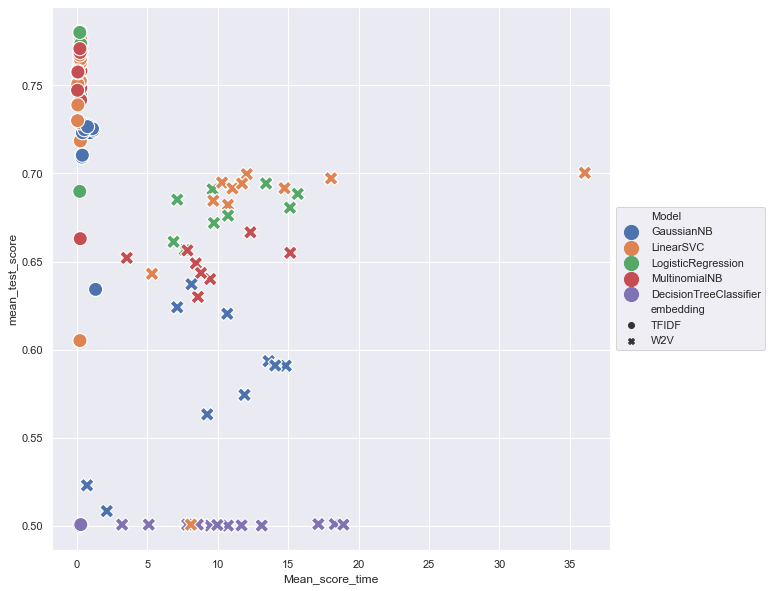

As we can see we have few models that are possible candidates: they have a pretty high accuracy and run pretty fast!

But this is not enough, let's see if the models are actually robust or the high accuracy was just due to a lucky selection of the dataset

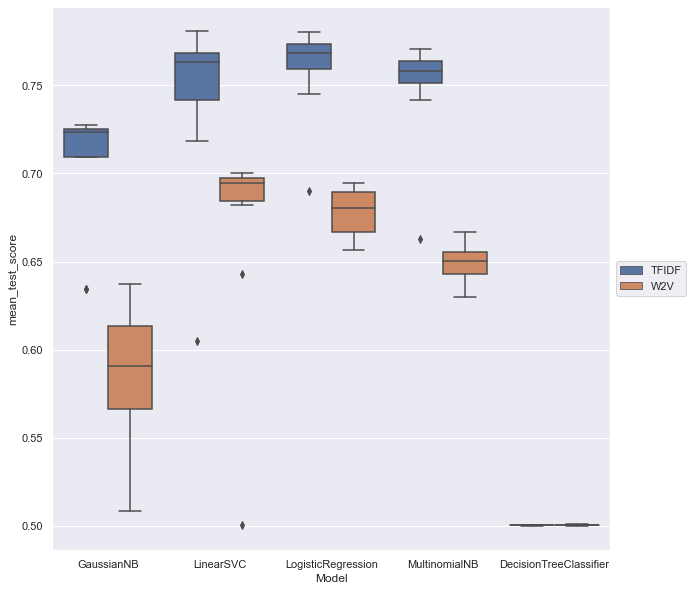

As can be seen all the models with $\text{TFIDF}$ tends to have a pretty low variance in terms of accuracy, especially the naive bayes models. Instead the models that use $\text{W2V}$ seems to have a pretty high variance in the results and this could be due to low performances of the word2vec embedding algorithm.

Also all the Decision Tree classifiers reach performance that are really close to a random classifier.

Let's have a look just to all those models that have an accuracy higher than $0.75$

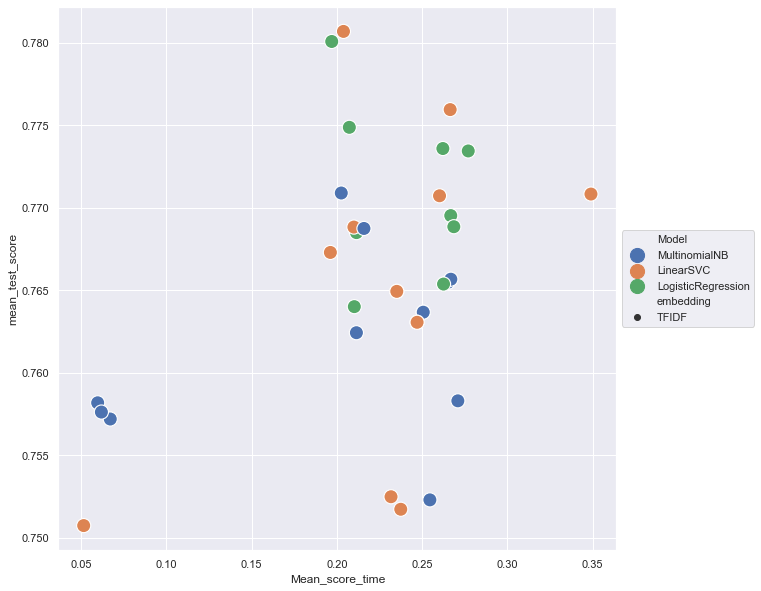

As can be seen only $TFIDF$ models manage to get an accuracy higher than $0.75$, but this could be due to the fact that $W2V$ is actually a Neural Network at it will need more data to provide a good embedding.

So before removing the models with $\text{W2V}$ let's see if computationally speaking they could be a good fit by filtering for only those models with a prediction time lower than $0.5$ seconds.

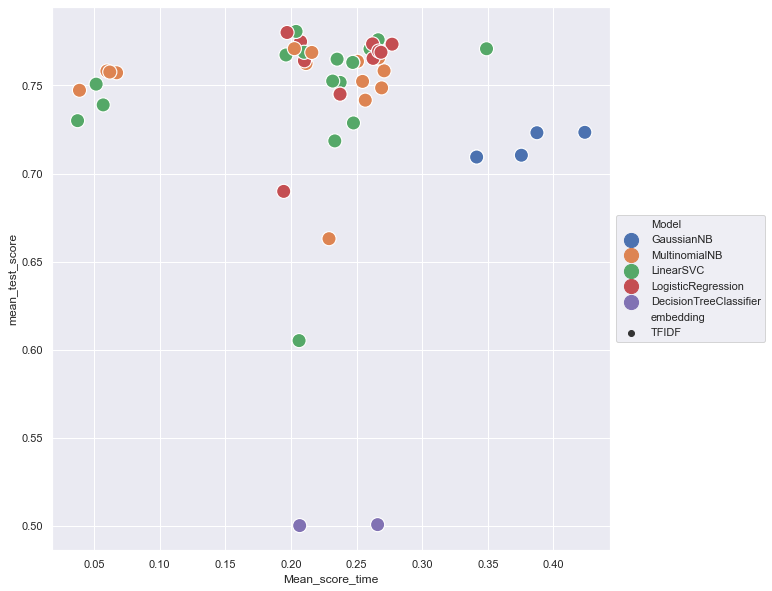

Also here no models with $\text{W2V}$ manage to have a suitable prediction time, hence we can discard these models from the candidates.

Another important aspect that should be analyzed is the robustness of the models that run really fast (and so use a lower number of parameters for word embeddings).

We will analyze this aspect using the box plot of accuracy for only those model configurations that have a score time lower than $0.5$ second.

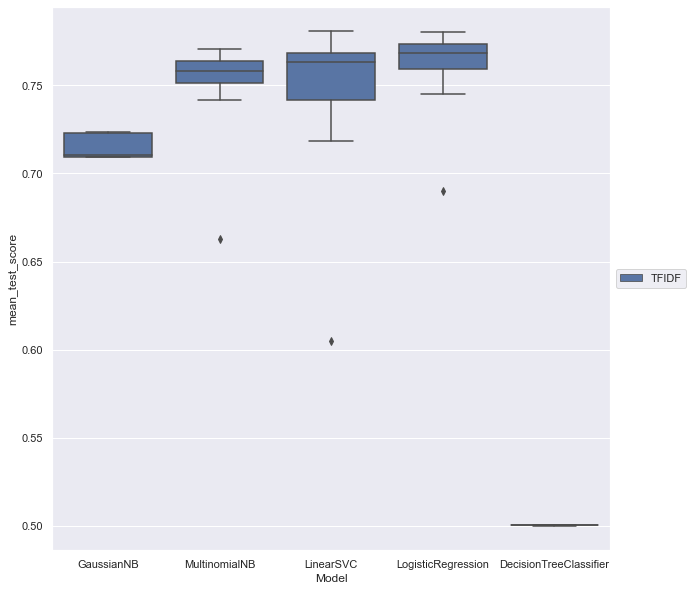

As can be seen all the models seem to be robust enough also with a lower number of parameters, so we can expect to obtain better performances training the models and the word embeddings with all the $1.6$ millions units of the dataset.

By all the results it is clear that decision trees must be removed by the candidates group.

By the analysis above we know that we have to use $\text{TFIDF}$ as embedding algorithm and that Decision Trees cannot be used.

Also looking at the graphs above we have that Gaussian Naive Bayes tends to be computationally more expensive than the others and doesn't manage to give optimal results, hence this model can be discarded too.

###### Second Screening

In this second screening step we will apply a random search over the same parameters for only the $2$ selected models: $\text{TFIDFLogisticRegression}$ and $\text{TFIDFMultinomialNB}$ and this time the models will be trained on all the $1.6$ million units of the dataset.

Around $50$ different models have been trained and here we can see the results in the same format as we did for the initial screening.